# Analysing Gym Wait Times Using Stochastic Gradient Descent

An interesting application of the Sotchastic Gradient Descent can be the analysis of waiting times at the gym. When are the best hours to go to the gym so that you avoid the crowds? We will use the “Crowdedness at the Campus Gym” dataset, which contains historic information about how crowded the campus gym is on a given day and hour, as well as other specific information about the specific days.

## Exploring the data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

gym = pd.read_csv('crowdness_gym_data.csv')

# Exploring the data

print(gym.info())
print(gym.head())

# Descriptive statistics
num_vars = gym.columns[gym.dtypes != 'object']
print("Numerical vars descriptives:")
print(gym[num_vars].describe())

cat_vars = gym.columns[gym.dtypes == 'object']
print("Categorical vars descriptives:")
print(gym[cat_vars].describe())

# Missings?
print("Numerical vars missings:")
print(gym[num_vars].isnull().sum().sort_values(ascending=False) / len(gym))
print('\n')
print("Categorical vars missings:")
print(gym[cat_vars].isnull().sum().sort_values(ascending=False) / len(gym))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB
None
   number_people                       date  timestamp  day_of_week  \
0             37  2015-08-14 17:00:11-07:00      61211            4   
1             45  2

The data looks as if it wouldn't contain any missings. Additionally, there are no complex qualitative variables requiring to be recoed into several dummy variables. Let's check some correlations and plot some of the variables.

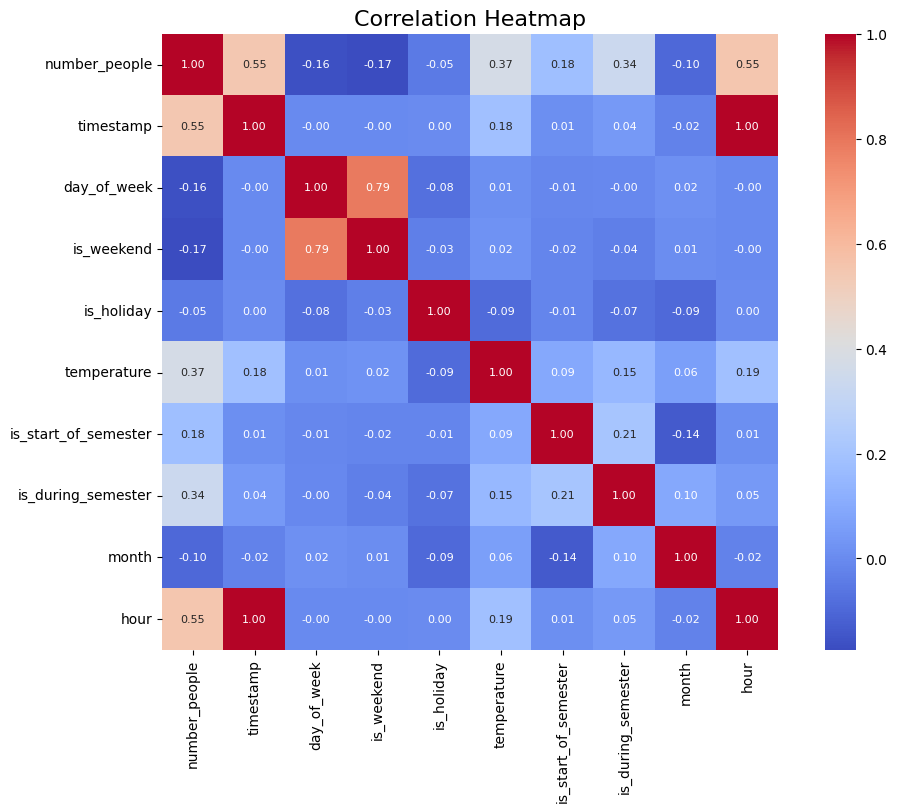

In [2]:
# Drop date column for correlation matrix
gym_no_date = gym.drop(columns=['date'])

# Calculate correlations

correlations = gym_no_date.corr()
#print(correlations)

# Heatmap

plt.figure(figsize=(12, 8))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True, annot_kws={"size": 8})
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


We can immediately see that the hour of the day has been derived from the original timestamp variable, since they are perfectly correlated. It makes more sense (and is easier to interpret) to use the `hour` variable instead. Just looking at the variables that most strongly correlate with `number_people`, we observe that hour of the day (r=.55, later hours more than early hours) correlate strongly with number of people in the gym. Higher temperatures are also positively correlated with crowdedness (r=.37). During the semester we also observe a more crowded gym (r=.34). During the weekend, it seems to be slightly less crowded (r=-.17). Generally, some variables could very well be confounders of each other, such as temperature (higher during summer months), semetser times are also correlated with temperatures and month.

Let's plot the distribution of some variables of interest.

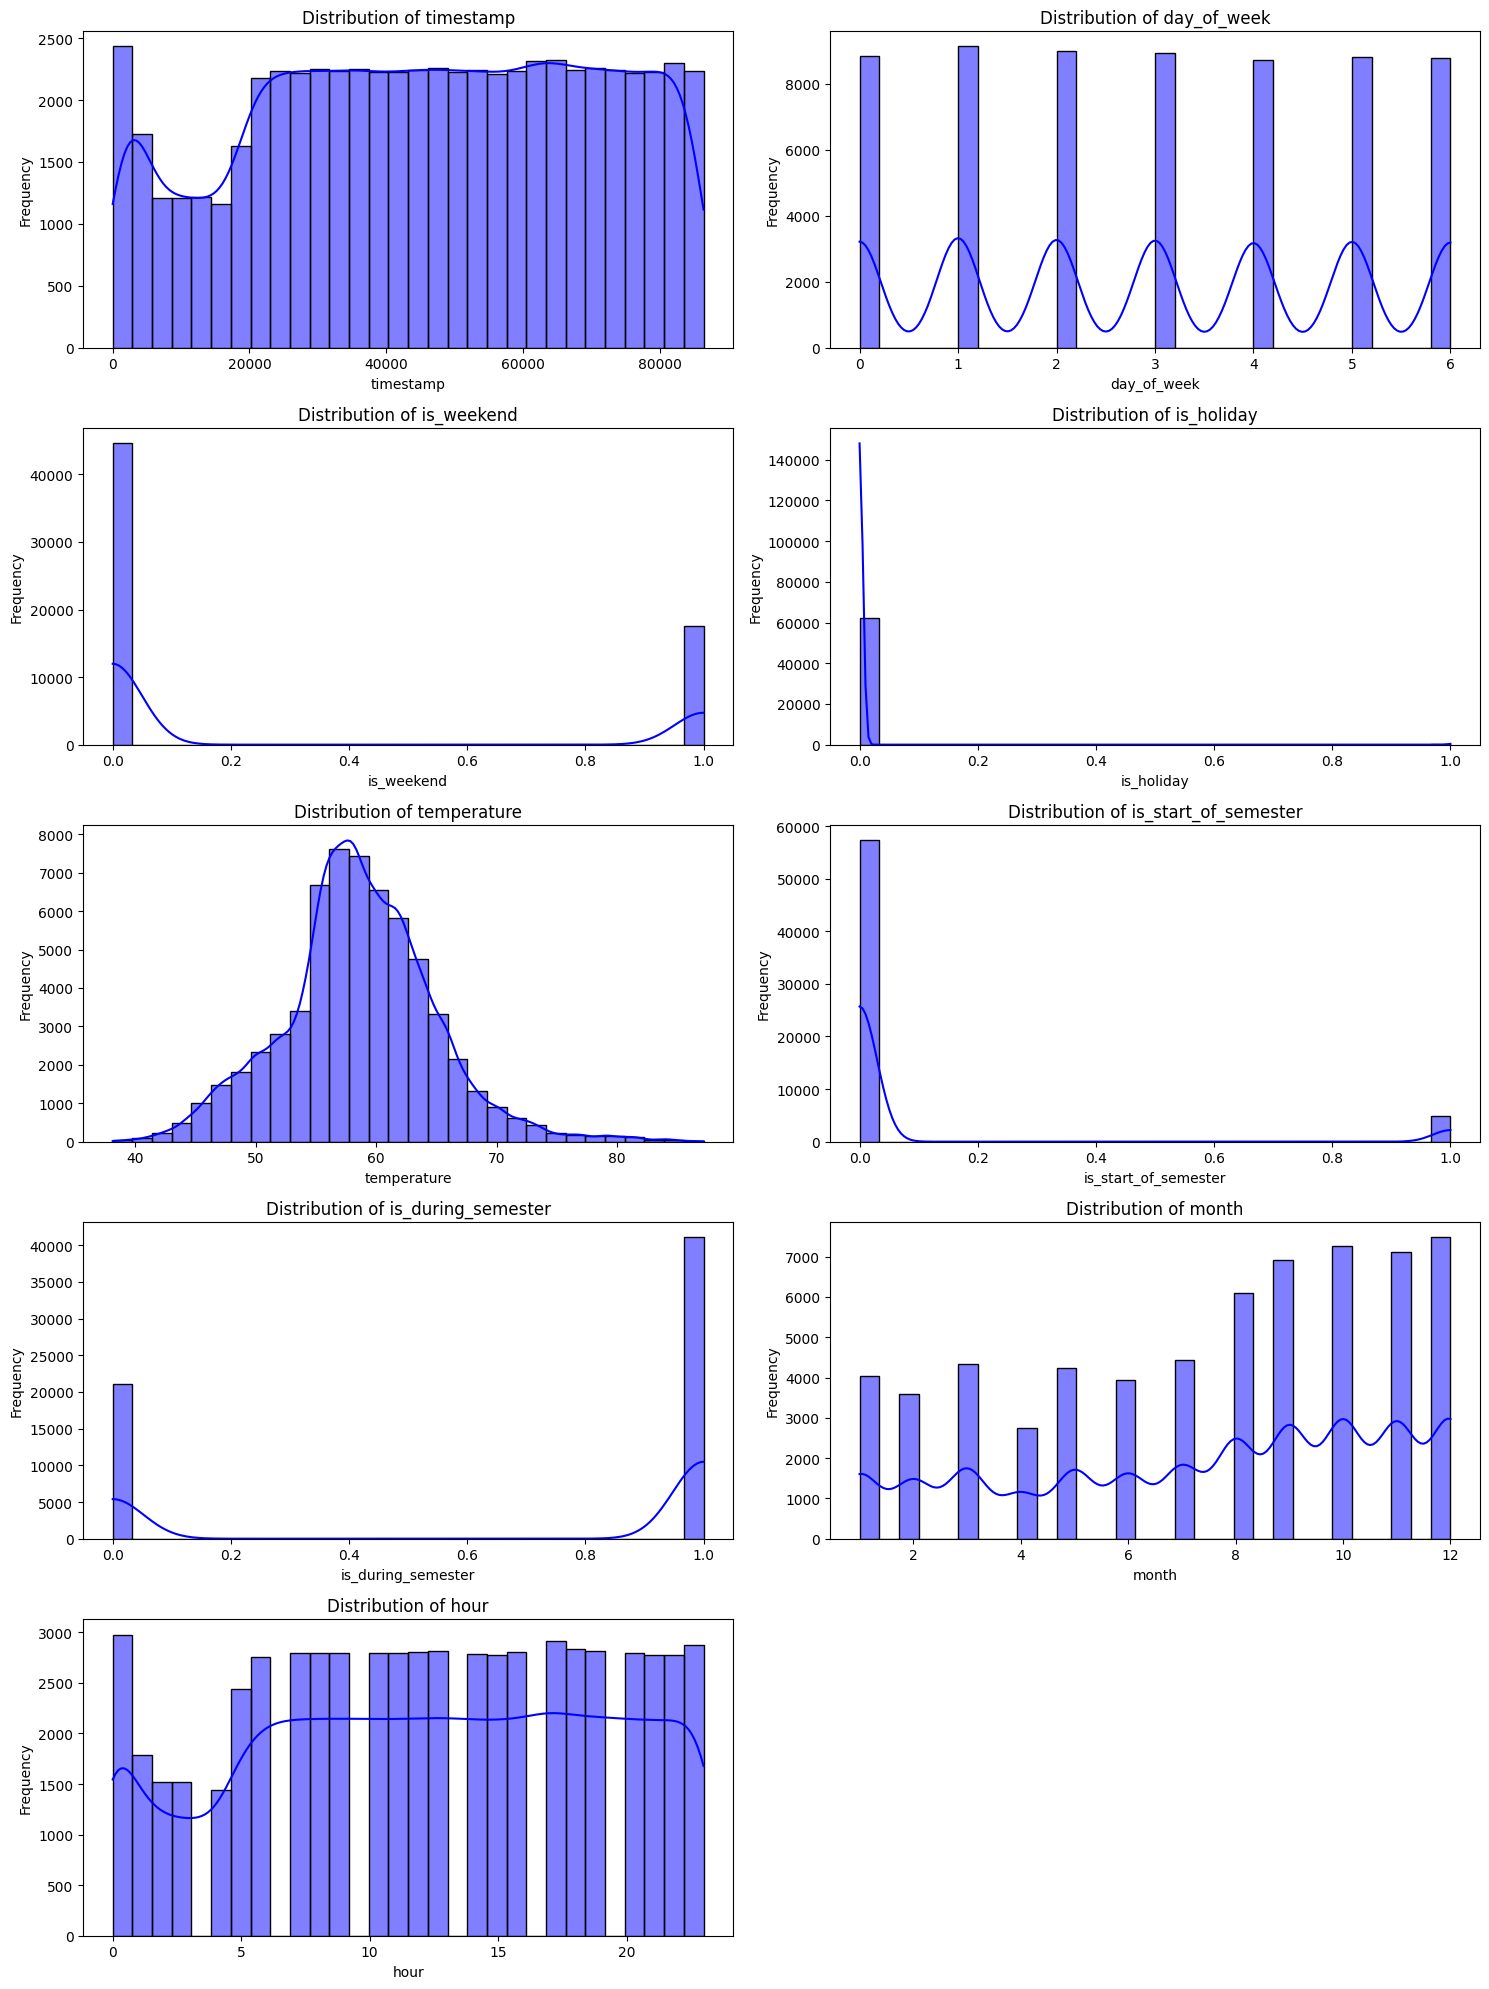

In [3]:
# Plot distributions of numerical variables

plt.figure(figsize=(15, 20))

for i, var in enumerate(num_vars[1:], 1):
     plt.subplot(5, 2, i)
     sns.histplot(gym_no_date[var], kde=True, color='blue', bins=30)
     plt.title(f'Distribution of {var}', fontsize=12)
     plt.xlabel(var)
     plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

None of the variables looks problematic. It makes sense to drop the `timestamp` variable (identical to `hour`).
Whether a set of dummies (`weekend`, `holiday`) or the `day_of_week`variable has more predictive power, cannot be decided now.
We just drop `timestamp` (in addition to the `date` variable) and keep all other variables in our DataFrame.

In [4]:
# drop timestamp variable

gym_updated = gym_no_date.drop(columns='timestamp')

## Setting up training and test sets

We have already imported the necessary packages above and will now split our data into training and test sets (80% training, 20% test), scale the data and train our model. While scaling makes the interpretation more difficult, it will probably be beneficial to the model fit. Through scaling, the data will be z-standardized (including the outcome), with 0 referring to the mean of each variable, and each unit change referring to a change of oine standard deviation of each variable. This will be helpful to keep in mind when interpreting the coefficients.

In [5]:
# Scaling the data

def scaler(df):
    scaler = StandardScaler()
    scaler.fit(df)
    df_scaled = scaler.transform(df)
    return df_scaled

gym_scaled = scaler(gym_updated)

# Setting up training and test sets

X = gym_scaled[:, 1:]
y = gym_scaled[:, 0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Training the model

Let's see how well we can train the model model now.

In [6]:
# Training the model

sgdr = SGDRegressor()                # Instantiating the model
sgdr.fit(X_train, y_train)           # Training the model

SGDRegressor()

In [7]:
# Inspecting the coefficients

intercept = sgdr.intercept_
coefficients = sgdr.coef_

In [8]:
# Create a regression summary table
regression_table = pd.DataFrame({
    "Coefficient": np.append(intercept, coefficients),
}, index=['Intercept', 'day_of_week', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'month',
       'hour'])

print(regression_table)


                      Coefficient
Intercept                0.017612
day_of_week             -0.096028
is_weekend              -0.099043
is_holiday              -0.032533
temperature              0.227510
is_start_of_semester     0.089418
is_during_semester       0.263490
month                   -0.111613
hour                     0.495834


Based on the coefficients, we see a number of pthe previous correlations confirmed. Later in the week, on weekends or holidays, as well as rather later during the year (i.e. winter months) will mean encountering a less crowded gym. Times to avoid would be, however, warmer days (presumably summer months), semester starts, as well as regular semester times. A strong positive coefficient shows that people frequent the gym more likely during the evenings, so early birds will be luckier if short waiting times are a priority.

Let us look at the model fit and see whether a simpler model might work better.

## Assessing the model fit on the training data

In [9]:
# Model fit

y_pred = sgdr.predict(X_train) # Making a prediction
train_mse = mean_squared_error(y_train, y_pred)
train_rmse = mean_squared_error(y_train, y_pred, squared=False)
train_abs = mean_absolute_error(y_train, y_pred)

R2_train = r2_score(y_train, y_pred)

print('Train MSE:', train_mse)
print('Train RMSE:', train_rmse)
print('Train MAE:', train_abs)
print('Train R2:', R2_train)

Train MSE: 0.49265645268190855
Train RMSE: 0.7018949014502873
Train MAE: 0.5380220957177637
Train R2: 0.5068489232580939


Since we have standardised our data, all the error indices refer to the standardised unit of measurement, i.e. standard deviations of the ouctome variable. For the RMSE of 0.70 this means that we are on average making an error of 0.70 standard deviations. The standard deviations of `number_people` is 22.68. So we approximately have an error of 0.70 * 22 = 15 people, by which we over or underestimate the number of people in the gym based on our set of predictor variables. The R-squared of 0.51 indicates that we are able to predict 51% of the variation in number of people in the gym. This is not too bad. Let's look at one simplified model in which we drop the `day_of_week` variable. (The relevant information seems to be between weekday vs. weekend.)

In [10]:
# dropping day_of_week from the model

X_train2 = X_train[:, 1:]

# Training the simpler model

sgdr2 = SGDRegressor()                # Instantiating the model
sgdr2.fit(X_train2, y_train)           # Training the model

# Inspecting the coefficients

intercept = sgdr2.intercept_
coefficients = sgdr2.coef_

# Create a regression summary table
regression_table = pd.DataFrame({
    "Coefficient": np.append(intercept, coefficients),
}, index=['Intercept', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'month',
       'hour'])

print(regression_table)

# Model fit simplified model

y_pred2 = sgdr2.predict(X_train2) # Making a prediction
train_mse2 = mean_squared_error(y_train, y_pred2)
train_rmse2 = mean_squared_error(y_train, y_pred2, squared=False)
train_abs2 = mean_absolute_error(y_train, y_pred2)

R2_train2 = r2_score(y_train, y_pred2)

print('Train MSE:', train_mse2)
print('Train RMSE:', train_rmse2)
print('Train MAE:', train_abs2)
print('Train R2:', R2_train2)

                      Coefficient
Intercept               -0.001148
is_weekend              -0.163703
is_holiday              -0.042307
temperature              0.229335
is_start_of_semester     0.071253
is_during_semester       0.262285
month                   -0.128582
hour                     0.499346
Train MSE: 0.494745917175079
Train RMSE: 0.7033817719951797
Train MAE: 0.5369173314601204
Train R2: 0.5047573609553744


There is no real improvement by simplifying the model in this way. Therefore, let us just stick with the initial model and see its performance on the test data.

## Measuring the performance of the model on the test data

In [11]:
# Model fit (test data)

y_pred = sgdr.predict(X_test) # Making a prediction
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
test_abs = mean_absolute_error(y_test, y_pred)

R2_test = r2_score(y_test, y_pred)

print('Test MSE:', test_mse)
print('Test RMSE:', test_rmse)
print('Test MAE:', test_abs)
print('Test R2:', R2_test)

Test MSE: 0.48825463513649336
Test RMSE: 0.6987521986630836
Test MAE: 0.5343473065176072
Test R2: 0.5136952684295388


Assessing the performance of our model on the test data shows a very similar picture to what we obsered in our training dataset. The fit-indices are almost identical. If anything, our performance even slightly improves, as the smaller RMSE and increased R-squared show.
Just to make sure, we can also check the performance of the simplified model.

In [12]:
# Model fit (test data) - simplified model

X_test2 = X_test[:, 1:]

y_pred2 = sgdr2.predict(X_test2) # Making a prediction
test_mse2 = mean_squared_error(y_test, y_pred2)
test_rmse2 = mean_squared_error(y_test, y_pred2, squared=False)
test_abs2 = mean_absolute_error(y_test, y_pred2)

R2_test2 = r2_score(y_test, y_pred2)

print('Test MSE:', test_mse2)
print('Test RMSE:', test_rmse2)
print('Test MAE:', test_abs2)
print('Test R2:', R2_test2)

Test MSE: 0.4909600472107911
Test RMSE: 0.700685412443267
Test MAE: 0.5341070570198521
Test R2: 0.5110006607435083


Both models deliver almost identical performance. The model including the weekday variable has a slightly smaller error, and there doesn't seem to be a problem with overfitting, as the results for the training and test sets are very close. We therefore stick to our initial model, including the day of the week variable.

## Visualizing the results

To see how our model performs, the best way is to visualize it. Here is the plot from our preferred (first) model, using line plots with the actual test data on the back and the predicted data on the front. The parts where the plots converge are the points where the model performed well, and the divergence in the plots is where the model performed poorly.

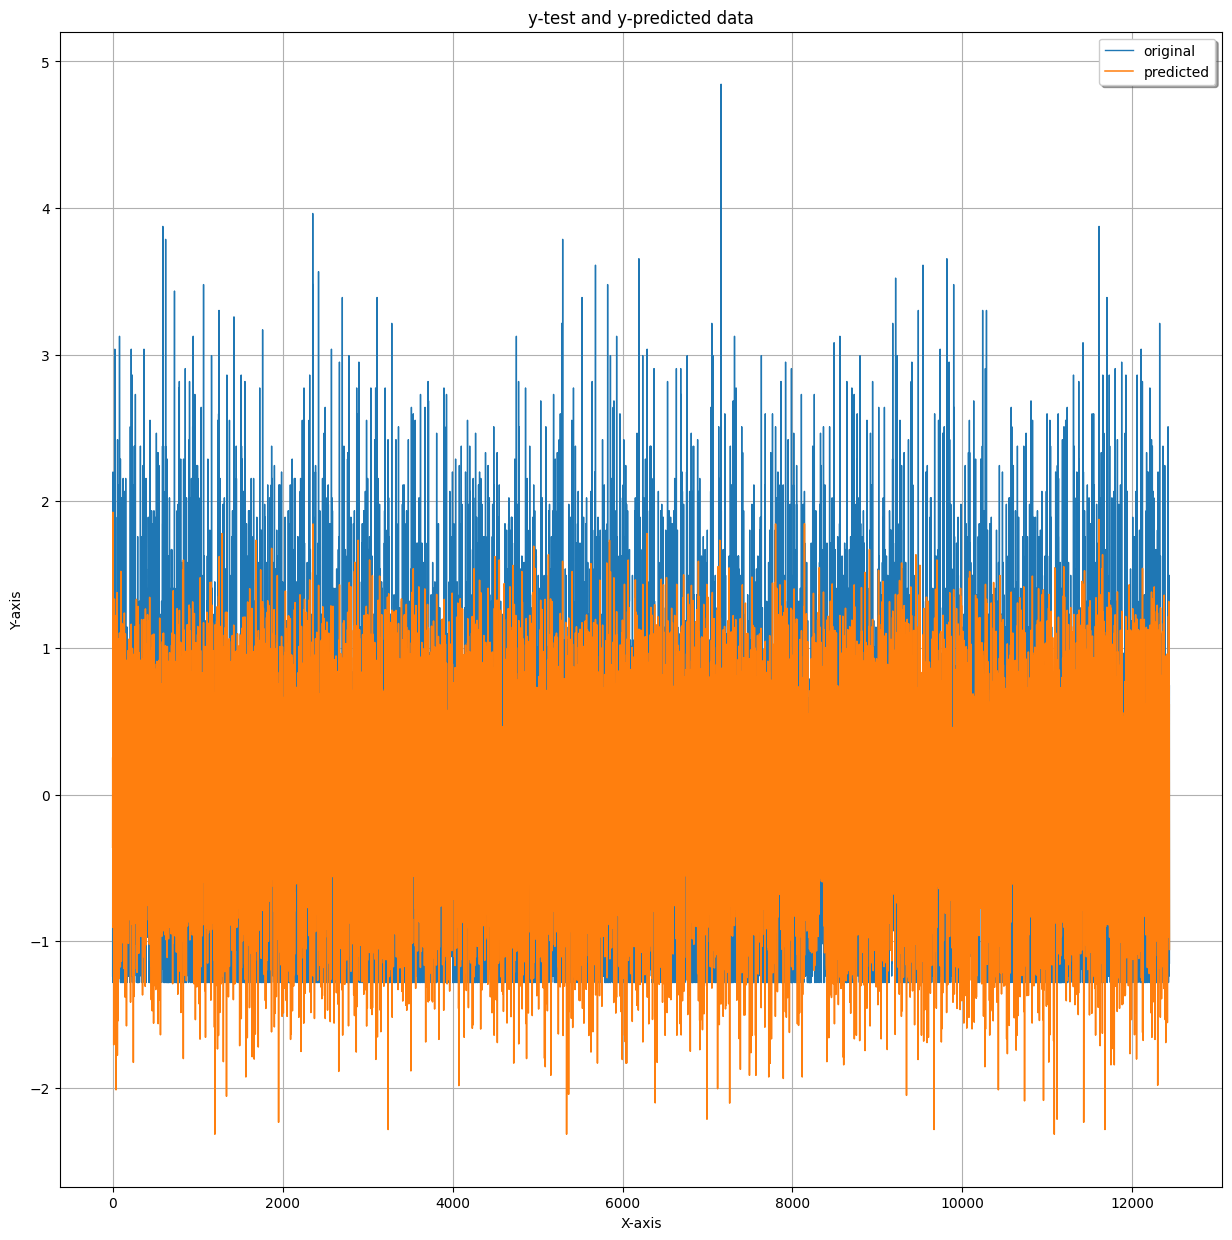

In [13]:
plt.figure(figsize=(15, 15))

x_ax = range(len(y_test))
plt.plot(x_ax, y_test, linewidth=1, label="original")
plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted")
plt.title("y-test and y-predicted data")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

This plot shows that, while there is a fair share of overlap between the original (blue) and the predicted data (orange), there certainly is room for improvement. It looks as if, in this simple form, our model is not as good in predicting crowded peak times, showing less variation than in the original data. We might be better of by including the weekday variable as dummies to model each specific day of the week.

## Summarizing the findings

Our goal was to predict less crowded times in the gym using a Stochastic Gradien Descent Linear Regression Model. Our findings showed that early hours rather than late hours during the day as well as weekends are good times to avoid crowding in the gym. Also the winter months and generally cooler days are correlated with less crowdedness.

While we could change the parametric form of the model (i.e. introduce differently coded variables), we could also try to tweak the model hyperparameters, like leraning rate and loss function, which we left untouched here. Overall, however, our model showed a satisfactory fit on a small set of predictors.